In [1]:
# =======================================
# DeepRacer Simple Log Visualization
# =======================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

/home/thudinh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [22]:
# --- Load CSV and track .npy file---
# replace main_dir with github repo directory
main_dir = "."
track_dir = "tracks"
eval_log_dir = os.path.join(main_dir, "eval_log/")
training_log_dir = os.path.join(main_dir, "training_log/")
#data from csv
df = pd.read_csv(os.path.join(eval_log_dir, "test4/ee19b687-141c-4b88-ae69-e6db5e8cc43c/sim-trace/evaluation/20250910090614-Pe-e-3GoQnmEnJiEcdkXLQ/evaluation-simtrace/0-iteration.csv"))
# /home/thudinh/Desktop/42Horsepower/eval_log/test4/ee19b687-141c-4b88-ae69-e6db5e8cc43c/sim-trace/evaluation/20250910090614-Pe-e-3GoQnmEnJiEcdkXLQ/evaluation-simtrace/0-iteration.csv
# #track waypoints
track_file = os.path.join(main_dir, track_dir, "2024_reinvent_champ_ccw.npy")

In [23]:
##Parameters
#----------
#waypoints : np.ndarray
#	Array of waypoints with shape (N, 6) → [x_center, y_center, x_left, y_left, x_right, y_right]

waypoints = np.load(track_file, allow_pickle=True)

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)

df["speed"] = df["throttle"]  # If throttle directly maps to speed (adjust if you have actual m/s)
# If throttle is gear-like instead of real m/s, you might need: df["speed"] = df["throttle"] * speed_scale
df["episode"] = df["episode"].astype(int)
#print("Is loop/ring? ", l_center_line.is_ring)

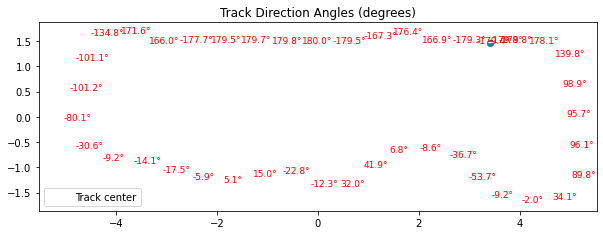

In [5]:
def plot_track_angles(center_line, step=5):
    """
    Plot the track and annotate each waypoint with the direction angle in degrees.

    step : int, optional
        Interval for showing labels (default=5).
    """
    xs, ys = center_line[:, 0], center_line[:, 1]

    # Compute direction vectors between consecutive points
    directions = np.roll(center_line, -1, axis=0) - center_line

    # Compute angles in degrees (-180 to 180)
    angles = np.degrees(np.arctan2(directions[:, 1], directions[:, 0]))

    plt.figure(figsize=(10, 5))
    plt.plot(xs, ys, "w-", linewidth=1, label="Track center")
    plt.scatter(xs[0], ys[0])
    # Annotate with angles
    for i in range(0, len(xs), step):
        plt.text(xs[i], ys[i], f"{angles[i]:.1f}°", fontsize=9, color="red")

    plt.gca().set_aspect("equal")
    plt.title("Track Direction Angles (degrees)")
    plt.legend()
    plt.show()
    return angles

angles = plot_track_angles(waypoints, step=2)

In [6]:
# Visualize a DeepRacer track from an .npy file.
def plot_track(center_line, inner_border, outer_border, show_wp_index=False, show_center_line=False):
	xs, ys = center_line[:, 0], center_line[:, 1]
	left_line = inner_border
	right_line = outer_border

	# Plot
	fig, ax = plt.subplots(figsize=(10, 5))

	ax.plot(left_line[:, 0], left_line[:, 1], 'k--', label="Left Border")
	ax.plot(right_line[:, 0], right_line[:, 1], 'k--', label="Right Border")
	if show_wp_index == True:
		for i in range(0, len(center_line)):
			plt.text(xs[i] - 0.05, ys[i] + 0.1, f"{i}", fontsize=7, color="green")
	if show_center_line == True:
		ax.scatter(xs, ys, s=10, c="green", label="Waypoints")
	ax.axis("equal")
	return fig, ax

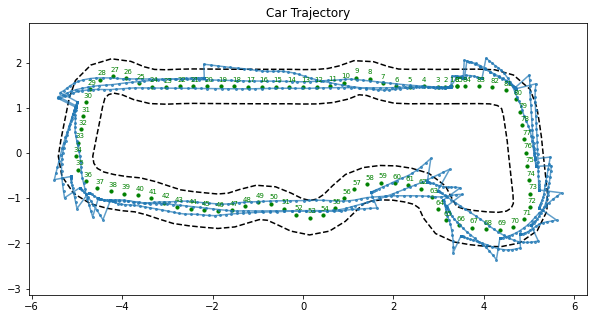

In [24]:
# --- 1. Plot Waypoints / Ideal Race Line ---
fig, ax = plot_track(center_line, inner_border, outer_border, True, True)
ax.plot(df["X"], df["Y"], marker="o", markersize=2, linestyle="-", alpha=0.7)
plt.title("Car Trajectory")
plt.show()

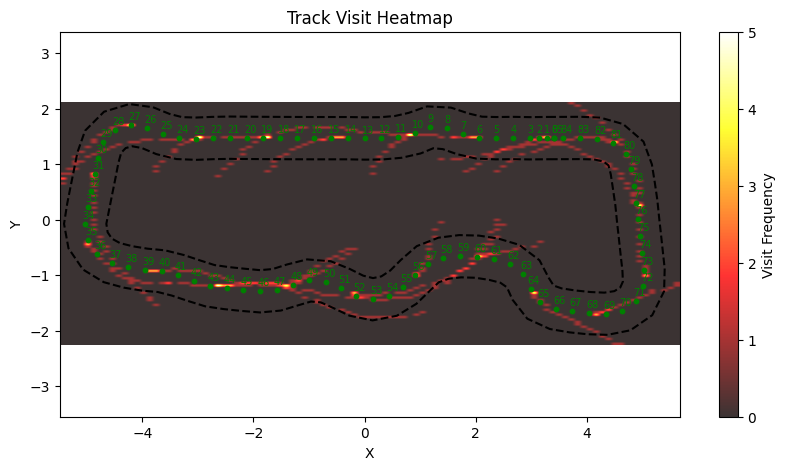

In [11]:
# --- 2. Heatmap of Track Visits ---
fig, ax = plot_track(center_line, inner_border, outer_border, True, True)
heatmap, xedges, yedges = np.histogram2d(df["X"], df["Y"], bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=0.8)
plt.colorbar(label="Visit Frequency")
plt.title("Track Visit Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

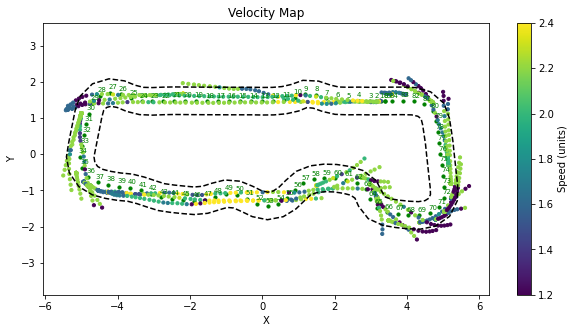

In [25]:
# --- 3. Velocity Map ---
fig, ax = plot_track(center_line, inner_border, outer_border, True, True)
sc = ax.scatter(df["X"], df["Y"], c=df["speed"], cmap="viridis", s=10)
fig.colorbar(sc, label="Speed (units)")
plt.title("Velocity Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

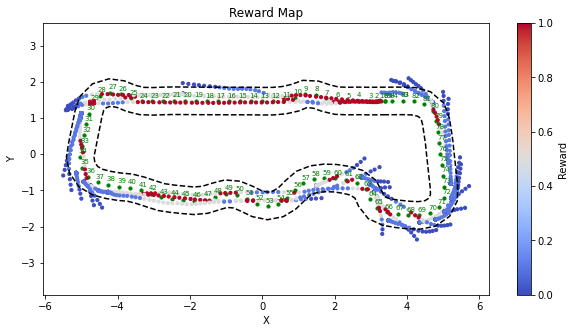

In [26]:
# --- 4. Reward Map ---
fig, ax = plot_track(center_line, inner_border, outer_border, True, True)
sc = ax.scatter(df["X"], df["Y"], c=df["reward"], cmap="coolwarm", s=10)
fig.colorbar(sc, label="Reward")
plt.title("Reward Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

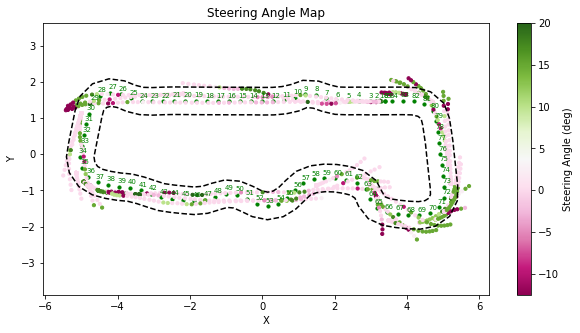

In [27]:
# =======================================
# 5. Steering Angle Map
# =======================================
fig, ax = plot_track(center_line, inner_border, outer_border, True, True)
sc = ax.scatter(df["X"], df["Y"], c=df["steer"], cmap="PiYG", s=10)
fig.colorbar(sc, label="Steering Angle (deg)")
plt.title("Steering Angle Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

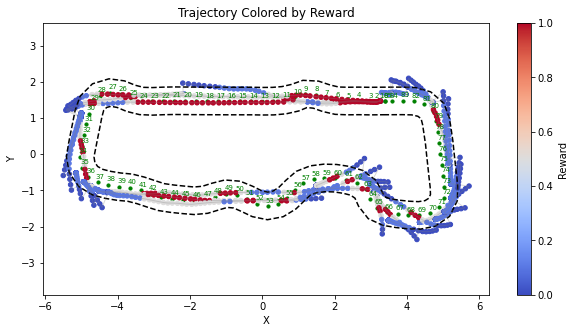

In [28]:
# =======================================
# 6. Reward Density Overlay on Trajectory
# =======================================
fig, ax = plot_track(center_line, inner_border, outer_border, True, True)
ax.plot(df["X"], df["Y"], color='grey', alpha=0.3, linestyle='-', linewidth=1)
sc = ax.scatter(df["X"], df["Y"], c=df["reward"], cmap="coolwarm", s=20)
fig.colorbar(sc, label="Reward")
plt.title("Trajectory Colored by Reward")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

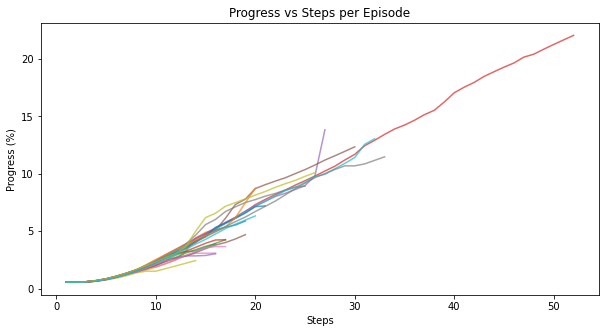

In [21]:
# =======================================
# 7. Episode-by-Episode Progress
# =======================================
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="steps", y="progress", hue="episode", palette="tab10", alpha=0.7, legend=False)
plt.title("Progress vs Steps per Episode")
plt.xlabel("Steps")
plt.ylabel("Progress (%)")
plt.show()